UNet demo
=========

In [21]:
# https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
# https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
# https://github.com/Mostafa-wael/U-Net-in-PyTorch/tree/main

import random
import itertools
import time
import copy

from functools import reduce
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, datasets
from torchvision import ops

from torchsummary import summary

## UNet

In [22]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last baseline block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512


        # Baseline
        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)


    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [23]:
class UNetMini(nn.Module):

    def __init__(self, num_classes):
        super(UNetMini, self).__init__()

        # Use padding 1 to mimic `padding='same'` in keras,
        # use this visualization tool https://ezyang.github.io/convolution-visualizer/index.html
        self.block1 = Sequential(
            Conv2d(3, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool1 = MaxPool2d((2, 2))

        self.block2 = Sequential(
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool2 = MaxPool2d((2, 2))

        self.block3 = Sequential(
            Conv2d(64, 128, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(128, 128, kernel_size=3, padding=1),
            ReLU()
        )

        self.up1 = UpsamplingNearest2d(scale_factor=2)
        self.block4 = Sequential(
            Conv2d(192, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU()
        )

        self.up2 = UpsamplingNearest2d(scale_factor=2)
        self.block5 = Sequential(
            Conv2d(96, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU()
        )

        self.conv2d = Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        out1 = self.block1(x)
        out_pool1 = self.pool1(out1)

        out2 = self.block2(out_pool1)
        out_pool2 = self.pool1(out2)

        out3 = self.block3(out_pool2)

        out_up1 = self.up1(out3)
        # return out_up1
        out4 = torch.cat((out_up1, out2), dim=1)
        out4 = self.block4(out4)

        out_up2 = self.up2(out4)
        out5 = torch.cat((out_up2, out1), dim=1)
        out5 = self.block5(out5)

        out = self.conv2d(out5)

        return out

## Model dataset

In [24]:
def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y


def generate_img_and_mask(height, width):
    shape = (height, width)

    # triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    # mesh_location = get_random_location(*shape)
    # square_location = get_random_location(*shape, zoom=0.8)
    # plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    # arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    # arr = add_mesh_square(arr, *mesh_location)
    # arr = add_filled_square(arr, *square_location)
    # arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        # add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        # add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
        #  add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks


def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr


def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))


def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array


def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))


def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr


def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr


def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr


def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)


def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])


def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))


def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()


def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)


def generate_images_and_masks_then_plot():
    # Generate some random images
    input_images, target_masks = generate_random_data(192, 192, count=3)

    for x in [input_images, target_masks]:
        print(x.shape)
        print(x.min(), x.max())

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [x.astype(np.uint8) for x in input_images]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

    # Left: Input image (black and white), Right: Target mask (6ch)
    plot_side_by_side([input_images_rgb, target_masks_rgb])


def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp


class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

## Training

### Data

In [25]:
def get_data_loaders():
    # use the same transformations for train/val in this example
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])

    train_set = SimDataset(500, transform = trans)
    val_set = SimDataset(100, transform = trans)

    image_datasets = {
        'train': train_set, 'val': val_set
    }

    batch_size = 20

    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
    }

    return dataloaders

### Training

Based on [Segmentation Metrics PyTorch Implementation](https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch)

#### Pixel accuracy
Pixel accuracy measures how many pixels are predicted correctly. In binary cases:  

$
Pixel Acc = \frac{TP + TN}{TP + TN + FP + FN}
$  

In multiclass cases it can be calculated from confusion matrix, by dividing the sum of diagonal elements (ture positives for all classes) with the total number of pixels.

#### Dice coeff
Dice evaluates the overlap rate of prediction results and ground truth; equals to f1 score in defination.  

$
Dice = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$  

#### Precision
Describes the purity of our positive detections relative to the ground truth.  

$
Precision = \frac{TP}{TP + FP}
$  

#### Recall
Describes the completeness of our positive predictions relative to the ground truth.  

$
Recall = \frac{TP}{TP + FN}
$  

### Specificity
Also known as true negative rate (TNR)  

$
Specificity = \frac{TN}{TN + FP}
$ 

In [29]:

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def overlap_metrics(pred, target, eps=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()

    tp = torch.sum(pred * target)  # TP
    fp = torch.sum(pred * (1 - target))  # FP
    fn = torch.sum((1 - pred) * target)  # FN
    tn = torch.sum((1 - pred) * (1 - target))  # TN

    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou = (tp + eps) / (tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)       

    return [pixel_acc, dice, precision, recall, specificity]

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    o_m = overlap_metrics(pred, target)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    metrics['px_acc'] += o_m[0].data.cpu().numpy() * target.size(0)
    metrics['dice_coef'] += o_m[1].data.cpu().numpy() * target.size(0)
    metrics['prec'] += o_m[2].data.cpu().numpy() * target.size(0)
    metrics['recall'] += o_m[3].data.cpu().numpy() * target.size(0)
    metrics['spec'] += o_m[4].data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


def train_model(model, dat_load, optimizer, scheduler, num_epochs=50):
    dataloaders = dat_load
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    train_loss_list = []
    val_loss_list = []

    train_px_acc_list = []
    val_px_acc_list = []

    train_prec_list = []
    val_prec_list = []

    train_start_time = time.time()

    for epoch in range(num_epochs):
        print('=' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    print(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
            
            if phase == 'train':
                print(metrics['loss'])
                train_loss_list.append(metrics['loss'] / epoch_samples)
                train_px_acc_list.append(metrics['px_acc'] / epoch_samples)
                train_prec_list.append(metrics['prec'] / epoch_samples)
            else:
                val_loss_list.append(metrics['loss'] / epoch_samples)
                val_px_acc_list.append(metrics['px_acc'] / epoch_samples)
                val_prec_list.append(metrics['prec'] / epoch_samples)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
 
    total_time_elapsed = time.time() - train_start_time 
    print('Best val loss: {:4f}, total train time {:.0f}m {:.0f}s'.format(best_loss, total_time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_loss_list, val_loss_list, train_px_acc_list, val_px_acc_list, train_prec_list, val_prec_list]


def run(UNet):
    num_class = 3
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = UNet(num_class).to(device)

    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

    model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)

    model.eval()  # Set model to the evaluation mode

    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # imagenet
    ])
    # # Create another simulation dataset for test
    test_dataset = SimDataset(3, transform = trans)
    test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

    # Get the first batch
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Predict
    pred = model(inputs)
    # The loss functions include the sigmoid function.
    pred = F.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    print(pred.shape)

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
    pred_rgb = [masks_to_colorimg(x) for x in pred]

    plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [30]:
class TrainRun():
    def __init__(self, unet_model,
                 n_epoch=5, n_class=3, n_test=2,
                 train_set_size=100, val_set_size=20):
        self.n_class = n_class
        self.n_epoch = n_epoch
        self.n_test = n_test

        self.train_set_size = train_set_size
        self.val_set_size = val_set_size

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = unet_model(self.n_class).to(self.device)

        self.optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=1e-4)
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer_ft, step_size=30, gamma=0.1)

    @staticmethod
    def __get_data_loaders__(train_set_size=500, val_set_size=100):
        # use the same transformations for train/val in this example
        trans = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

        train_set = SimDataset(train_set_size, transform = trans)
        val_set = SimDataset(val_set_size, transform = trans)

        image_datasets = {'train': train_set,
                          'val': val_set}
        
        batch_size = 10
        dataloaders = {'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1),
                       'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)}

        return image_datasets, dataloaders

    def exexute_train(self):
        self.image_dataset, self.dataloader = self.__get_data_loaders__(self.train_set_size, self.val_set_size)

        self.model, self.metrics_list = train_model(self.model, self.dataloader,
                                                    self.optimizer_ft, self.exp_lr_scheduler,
                                                    num_epochs=self.n_epoch)

        self.train_loss = self.metrics_list[0]
        self.val_loss = self.metrics_list[1]
        self.train_px_acc = self.metrics_list[2]
        self.val_px_acc = self.metrics_list[3]
        self.train_prec = self.metrics_list[4]
        self.val_prec = self.metrics_list[5]

        plt.figure(figsize=(10,4))
        plt.plot(self.train_loss, label='train loss',
                 marker='o', color='k')
        plt.plot(self.val_loss, label='validation loss',
                 marker='o', linestyle='--', color='k')
        
        plt.plot(self.train_px_acc, label='train px accuracy',
                 marker='^', color='r')
        plt.plot(self.val_px_acc, label='validation px accuracy',
                 marker='^', linestyle='--', color='r')

        plt.plot(self.train_prec, label='train precision',
                 marker='v', color='b')
        plt.plot(self.val_prec, label='validation precision',
                 marker='v', linestyle='--', color='b')

        plt.xticks(range(len(self.train_loss)))
        plt.xlabel('epoch')
        plt.ylabel('value')
        plt.legend()
        plt.show

    def execute_test(self, test_set_size=2):
        self.model.eval()  # Set model to the evaluation mode

        trans = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        # # Create another simulation dataset for test
        self.test_dataset = SimDataset(test_set_size, transform = trans)
        test_loader = DataLoader(self.test_dataset, batch_size=test_set_size, shuffle=False, num_workers=0)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Get the first batch
        inputs, labels = next(iter(test_loader))
        self.inputs = inputs.to(device)
        self.labels = labels.to(device)

        # Predict
        self.pred = self.model(inputs)
        # The loss functions include the sigmoid function.
        self.pred = F.sigmoid(self.pred)
        self.pred = self.pred.data.cpu().numpy()
        print(self.pred.shape)

        for i in range(inputs.cpu().numpy().shape[0]):
            one_img = self.inputs.cpu()[i]
            one_img = torch.swapdims(self.inputs.cpu()[0], 0, -1).to(torch.uint8)
            one_msk = self.labels.cpu()[i]
            one_msk = torch.swapdims(torch.cat((one_msk, torch.unsqueeze(torch.zeros_like(one_msk[0]), 0)), dim=0),0,-1)
            one_prd = torch.tensor(self.pred[i])
            one_prd = torch.swapdims(torch.cat((one_prd, torch.unsqueeze(torch.zeros_like(one_prd[0]), 0)), dim=0),0,-1)

            fig, ax = plt.subplots(ncols=3, figsize=(15,5))
            ax[0].imshow(one_img)
            ax[0].set_title('Img')
            ax[0].set_axis_off()
            ax[1].imshow(one_msk)
            ax[1].set_title('Mask')
            ax[1].set_axis_off()
            ax[2].imshow(one_prd)
            ax[2].set_title('Segmentation')
            ax[2].set_axis_off()
            plt.tight_layout()
            plt.show()

Epoch 0/0
----------
tensor(0.8575, grad_fn=<AddBackward0>)
tensor(0.8544, grad_fn=<AddBackward0>)
tensor(0.8519, grad_fn=<AddBackward0>)
tensor(0.8500, grad_fn=<AddBackward0>)
tensor(0.8456, grad_fn=<AddBackward0>)
tensor(0.8433, grad_fn=<AddBackward0>)
tensor(0.8409, grad_fn=<AddBackward0>)
tensor(0.8361, grad_fn=<AddBackward0>)
tensor(0.8320, grad_fn=<AddBackward0>)
tensor(0.8276, grad_fn=<AddBackward0>)
LR 0.0001
84.3915981054306
train: bce: 0.699890, dice: 0.987942, loss: 0.843916, px_acc: 0.496789, dice_coef: 0.012027, prec: 0.006085, recall: 0.513499, spec: 0.496690
tensor(0.8225)
tensor(0.8221)
val: bce: 0.657057, dice: 0.987590, loss: 0.822323, px_acc: 0.518432, dice_coef: 0.012375, prec: 0.006264, recall: 0.509967, spec: 0.518482
saving best model
1m 3s
Best val loss: 0.822323, total train time 1m 3s
(5, 2, 192, 192)


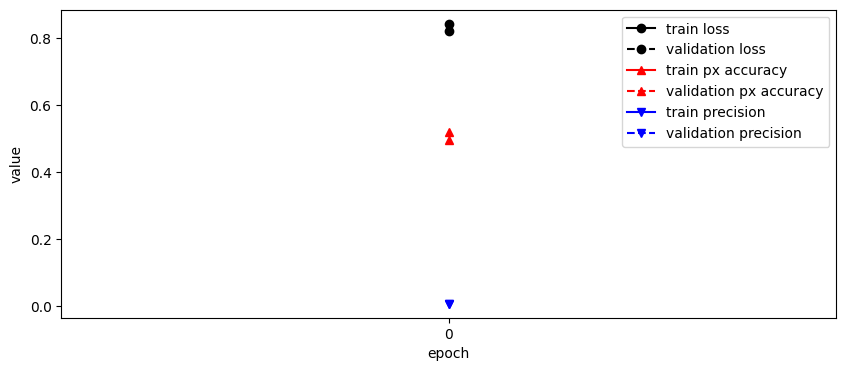

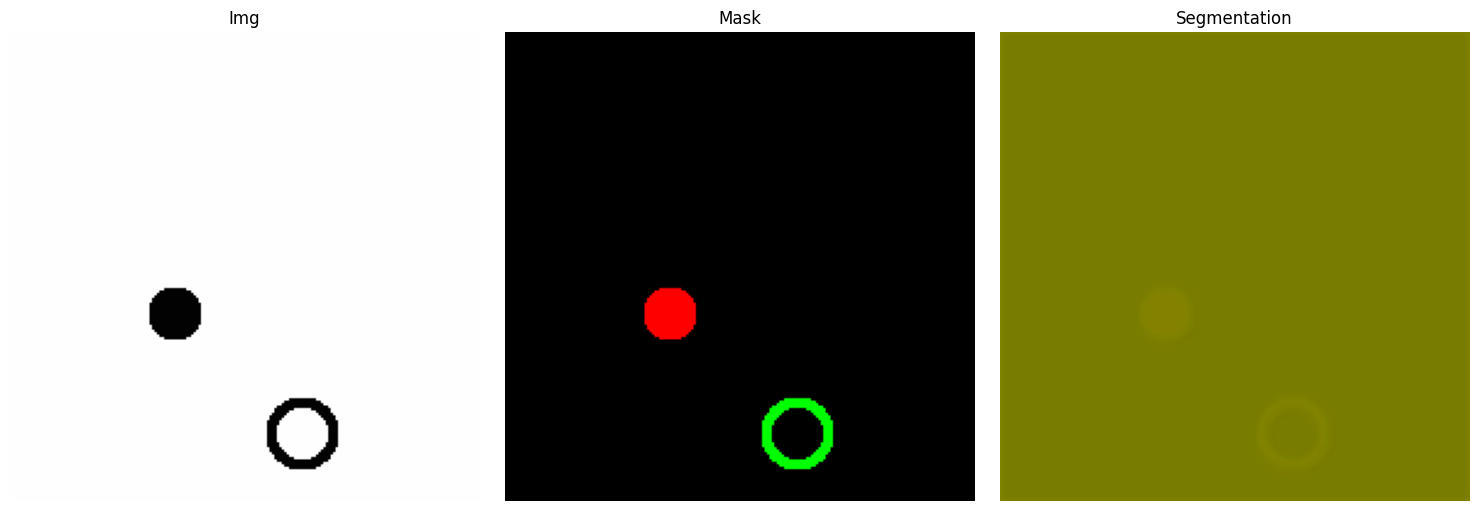

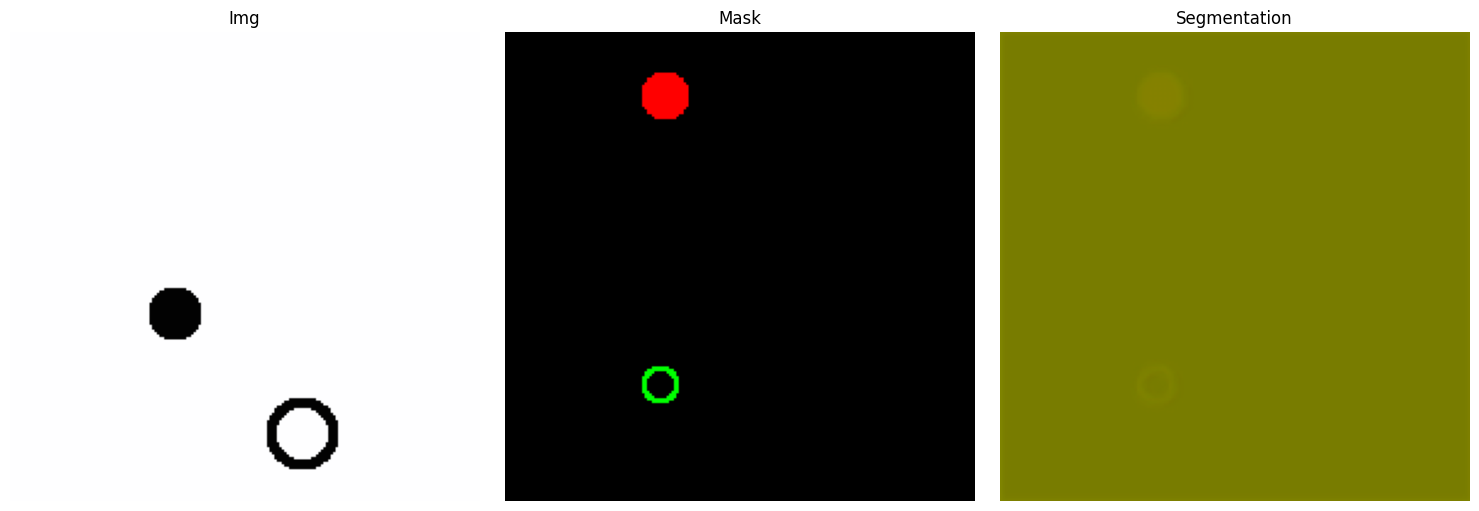

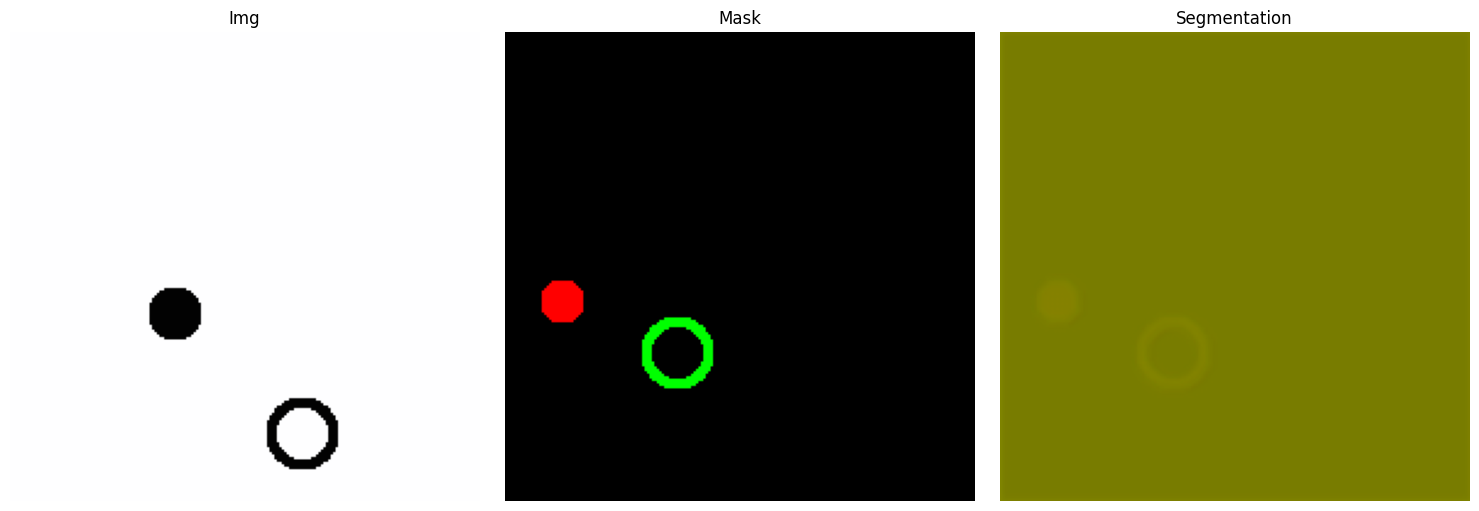

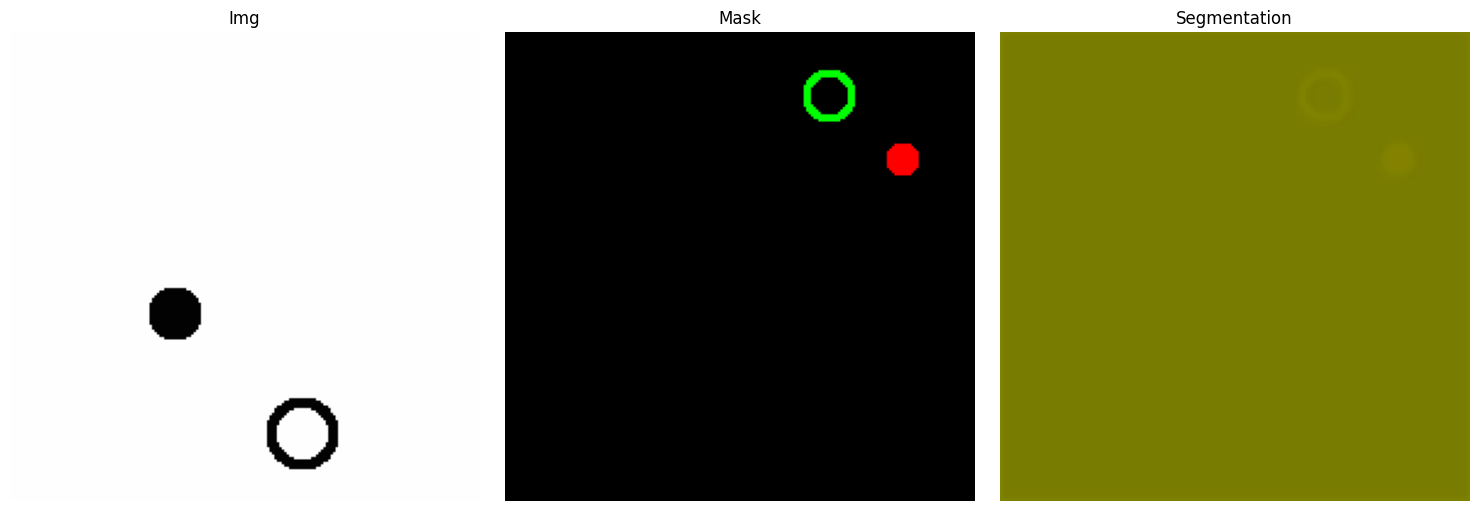

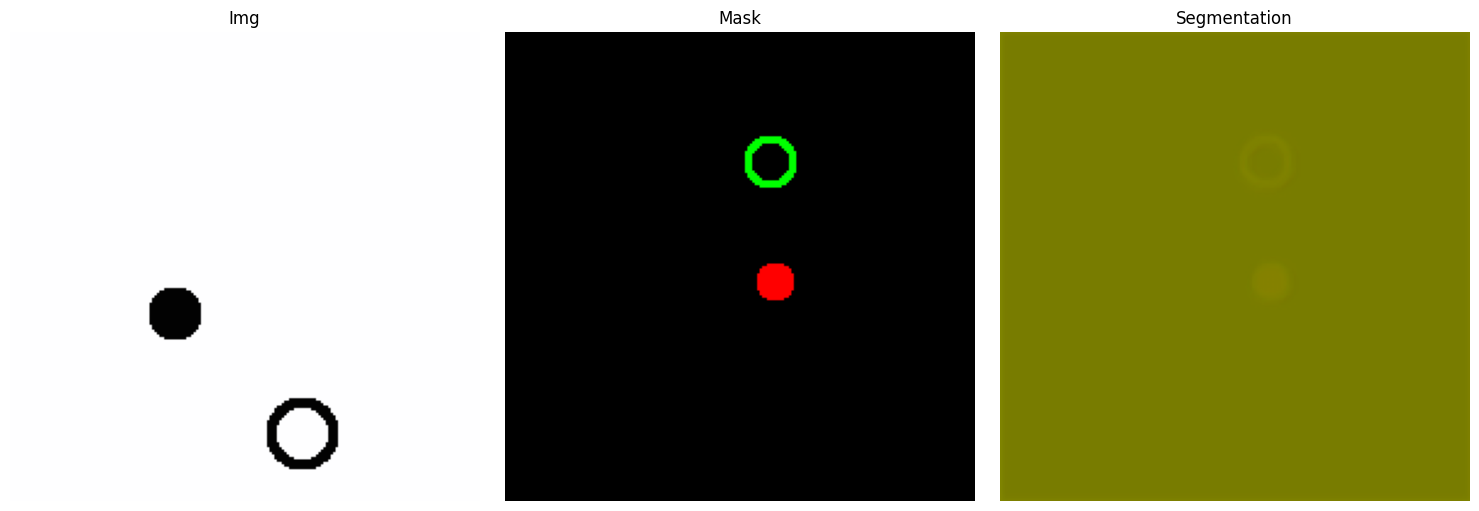

In [32]:
demo_train = TrainRun(UNet, n_epoch=1, n_class=2)
demo_train.exexute_train()
demo_train.execute_test(test_set_size=5)

In [ ]:
one_msk = torch.tensor(demo_train.pred[0])
one_msk = torch.swapdims(torch.cat((one_msk, torch.unsqueeze(torch.zeros_like(one_msk[0]), 0)), dim=0),0,-1)
# a = torch.swapdims(demo_train.inputs.cpu()[0], 0, -1).to(torch.uint8)

plt.figure(figsize=(10,10))
plt.imshow(one_msk[...,1], cmap='jet')

In [ ]:
torch.save(demo_train.model.state_dict(), '308_cirt-ring_unet.pt')

# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()